# Objective

The objective of this project is to develop a predictive model capable of estimating property prices within the city of CABA (Ciudad Autónoma de Buenos Aires), Argentina. By leveraging property data from Properati, the project aims to identify key factors that influence real estate prices—such as location, property type, surface area, and amenities — and use them to build a model that can accurately forecast the market value of new listings. This can serve as a valuable tool for buyers, sellers, and real estate professionals seeking data-driven insights in a dynamic urban market.

# Import and install libraries

In [5]:
#Installs
!pip install unidecode

In [6]:
# Sklearn
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

#Other imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from unidecode import unidecode
import unicodedata
import geopandas as gpd
from shapely.geometry import Point
import time

In [7]:
import warnings
warnings.filterwarnings('ignore') #For easier readability of this project.

# Loading the data

In [8]:
#Loading the data from Google drive
from google.colab import drive
drive.mount('/content/drive')
DIR = '/content/drive/MyDrive/properati_price_prediction/data'

Mounted at /content/drive


In [9]:
df_train = pd.read_csv(f"{DIR}/entrenamiento.csv", index_col="id") # Train dataset
df_test = pd.read_csv(f"{DIR}/a_predecir.csv", index_col="id") # Prices to be predicted

In [10]:
# Define useful plots
def plot_prop_type(DF_TRAIN, DF_TEST, TITULO):
  # Plots property tipe in each dataset
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    fig.suptitle(TITULO, fontsize=12)
    sns.histplot(DF_TRAIN["property_type"], ax=axes[0], color='blue')
    axes[0].set_title('Property Type - Dataset Train')
    sns.histplot(DF_TEST["property_type"], ax=axes[1], color='orange')
    axes[1].set_title('Property Type - Dataset Test')


    for ax in axes:
        for label in ax.get_xticklabels():
            label.set_rotation(25)


def plot_ubicacion_propiedades(DF, SUPERTITULO, COLOR):
  #Plot several spatial location variables L1 to L4
    fig, axes = plt.subplots(2, 2, figsize=(10,6))
    fig.suptitle(SUPERTITULO)

    sns.countplot(data = DF, x='l1', ax=axes[0,0], color=COLOR)
    axes[0,0].set_title('l1 - Administrative level: country')

    sns.countplot(data= DF, x='l2', ax=axes[0,1], color=COLOR)
    axes[0,1].set_title('l2 - Administrative level: province (usually)')

    sns.countplot(data= DF, x='l3', ax=axes[1,0], color=COLOR)
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    axes[1,0].set_title('l3 - Administrative level: city (usually)')

    sns.countplot(data= DF, x='l4', ax=axes[1,1], color=COLOR)
    axes[1,1].set_title('l4 - Administrative level: district/neighborhood (usually)')


def plot_curr_type(DF_TRAIN, DF_TEST, TITULO):
  #Plots currencies in which the properties are advertised
     fig, axes = plt.subplots(1, 2, figsize=(8,5))
     fig.suptitle(TITULO, fontsize=12)
     sns.histplot(DF_TRAIN["currency"], ax=axes[0], color='blue')
     axes[0].set_title('Property Type - Dataset Train')
     sns.histplot(DF_TEST["currency"], ax=axes[1], color='orange')
     axes[1].set_title('Property Type - Dataset Test')

     for ax in axes:
         for label in ax.get_xticklabels():
             label.set_rotation(45)

# Data cleaning and preprocessing

Translation note:
* Departamentos = Flat
* Casas = Houses
* Cocheras =  Garages

### Missing price values
Before training any models, it's important to ensure that the target variable (price) is properly defined.

* U check whether all rows in `df_train` contain a value for price.

* If any values are missing (_i.e._, `NaN`), drop those rows, since price is the target I'm trying to predict.

In [11]:
df_train['price'].isnull().sum()
df_train = df_train.dropna(subset=['price'])

### Property types in each dataset

* To gain a better understanding of the dataset, I start by exploring the types of properties it contains.

* Analyzing property types helps reveal structural differences that may affect model performance or introduce bias.

* I focus on the `property_type` column in both the training (`df_train`) and test (`df_test`) datasets.


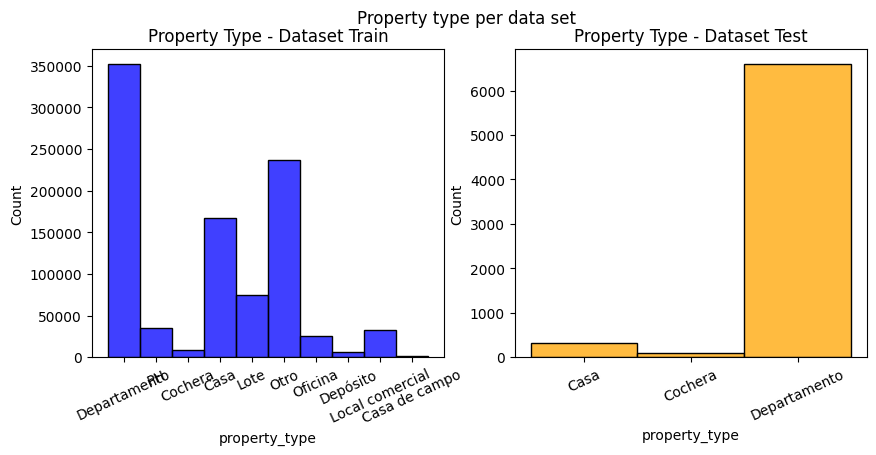

In [12]:
plot_prop_type(df_train, df_test, 'Property type per data set')

In [13]:
df_train = df_train[df_train["property_type"].isin(["Casa", "Cochera", "Departamento"])]

### Location of properties per L1 and L2

Properties must be located in the same target area:
  * Argentina  
    - The dataset includes listings from across Argentina, but for consistency and modeling accuracy, I limit the scope to a specific region.
  * CABA (Ciudad Autónoma de Buenos Aires)  
    - I focus specifically on properties located in CABA, the capital city, as it has a high density of listings, reliable geographic and pricing data.


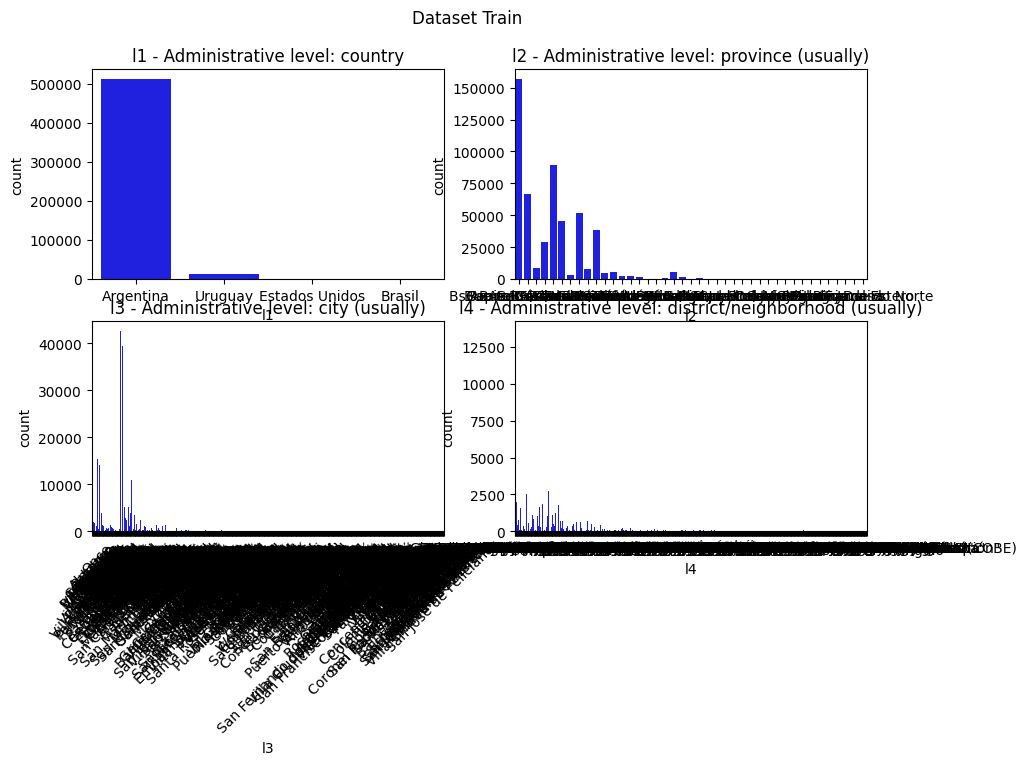

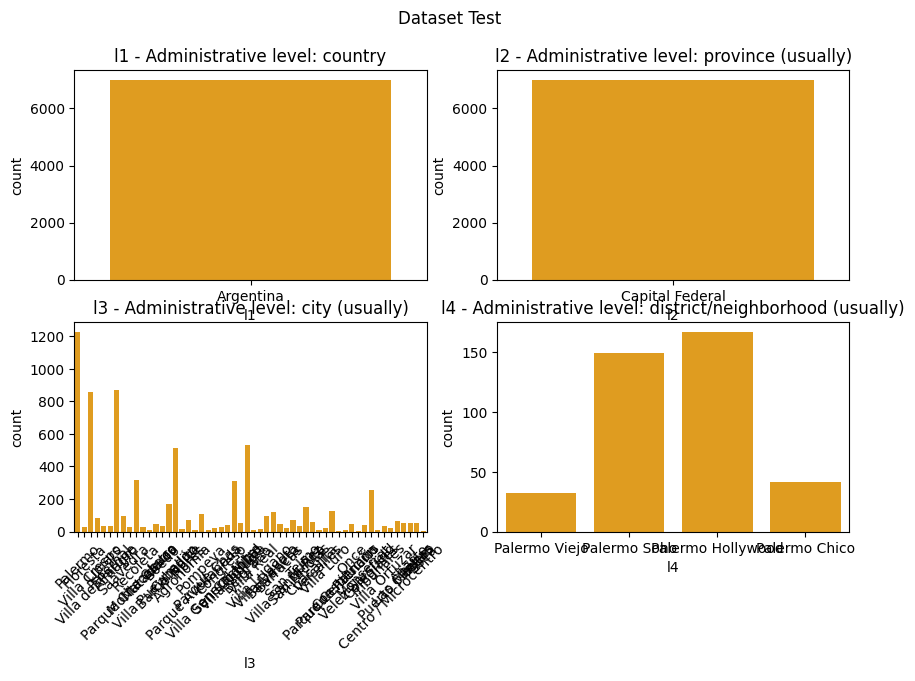

In [14]:
plot_ubicacion_propiedades(df_train, 'Dataset Train', 'blue')
plot_ubicacion_propiedades(df_test, 'Dataset Test', 'orange')

In [15]:
df_train = df_train.loc[(df_train["l1"] == "Argentina")]
df_train = df_train.loc[(df_train["l2"] == "Capital Federal")]

### Operation type

* Only interested in properties for sale.
* Property operations in Argentina are only performed in US Dollars.

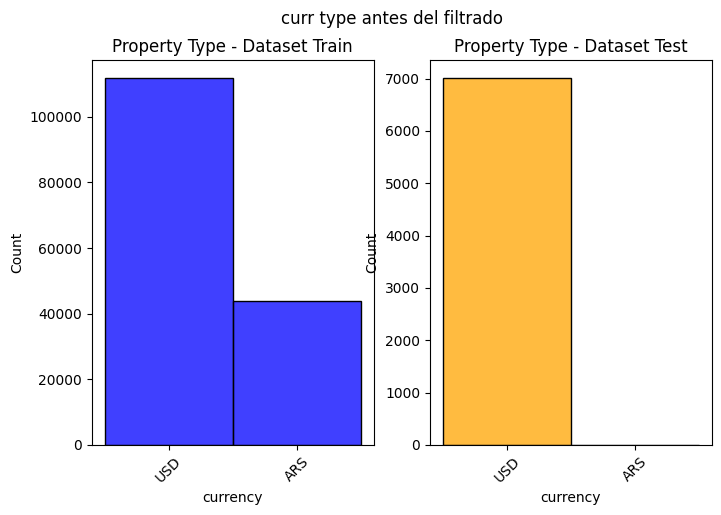

In [16]:
plot_curr_type(df_train, df_test, 'curr type antes del filtrado')

In [17]:
df_train = df_train.loc[(df_train["operation_type"] == "Venta")]
df_train = df_train.loc[(df_train["currency"] == "USD")]

### Exact duplicates

* Duplicates row may overrepresent a property type, location or any other value.
* Duplicates are erased maintaining the first appearance of the record.
* Only keep them as long as these are true different entities that have equal values, else, discard them. (This does not preclude the same property being overrepresented due to republishing)

In [18]:
df_train = df_train.drop_duplicates(keep='first')

### Neighborhood. imputation

* Fill L4 with the values from L4 itself, keeping L4 as is because I have different "Palermo" and that subdivision is convenient.
* Re-map Distrito Audiovisual and Catalinas.

In [19]:
for df in [df_train, df_test]:
    df.loc[df['l3'] == 'Distrito Audiovisual', 'l3'] = 'Chacarita'
    df.loc[df['l3'] == 'Catalinas', 'l3'] = 'Retiro'
    df.loc[:, 'l4'] = df['l4'].fillna(df['l3'])

df_train['l4'].isna().sum()
df_train = df_train.dropna(subset=['l4'])

### Missing neighborhoods

* If there are missing neighborhoods, search for them and try to complete them manually based on the description.
* If it's an unspecified neighborhood or outside of CABA, I identify it as such.

In [20]:
df_train_nan_l4 = df_train[df_train['l4'].isna()]
df_test_nan_l4 = df_test[df_test['l4'].isna()]

indices =list(df_test_nan_l4.index)
valores_nuevos = ['Boca','Boca', 'Fuera de CABA', 'Fuera de CABA', 'Fuera de CABA', 'Villa del Parque', 'Las Cañitas', 'Villa Urquiza' ]

for idx, val in zip(indices, valores_nuevos):
    df_test.loc[idx, 'l4'] = val

### Surface imputation

* Use of internal statistics to impute null values when both are missing.
* Use of covered surface when total surface is missing and viceversa.

In [21]:
def graficar_heatmaps(df_train, df_test, columna, titulo=''):
  #Plots heatmaps for both datasets
  #Receives as an input a column parameter to be adaptable for different variables you'd like to examine
    def matriz(df):
        return df.pivot_table(index='l4', columns='property_type', values=columna, aggfunc='mean')

    fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
    fig.suptitle(titulo, fontsize=14, y=0.98)

    for ax, df, name, cmap in zip(axes,[df_train, df_test],['df_train', 'df_test'], ['YlGnBu', 'YlOrRd']):
        sns.heatmap(matriz(df), ax=ax, cmap=cmap, annot=True, fmt=".1f")
        ax.set_title(f'{name}: {columna} Mean')
        ax.set_xlabel('Property type')
        ax.set_ylabel('Neighborhood (l4)' if name == 'df_train' else '')

    plt.tight_layout()
    plt.show()

medianas = df_train.groupby(['l4', 'property_type', 'rooms'])[['surface_covered', 'surface_total']].median()

df_train = df_train.merge(medianas, how = 'left', on = ['l4', 'property_type', 'rooms'], suffixes = ('', '_med'))

df_train['surface_covered'] = df_train['surface_covered'].fillna(df_train['surface_covered_med'])
df_train['surface_total']   = df_train['surface_total'].fillna(df_train['surface_total_med'])

df_train.drop(columns=['surface_covered_med', 'surface_total_med'], inplace=True)

df_train = df_train[~(df_train['surface_covered'] > df_train['surface_total'])] # Sanity check

for df in [df_train, df_test]:
    df['surface_covered'].fillna(df['surface_total'], inplace=True)  #Imputar NA's
    df['surface_total'].fillna(df['surface_covered'], inplace=True)  #Imputar NA's

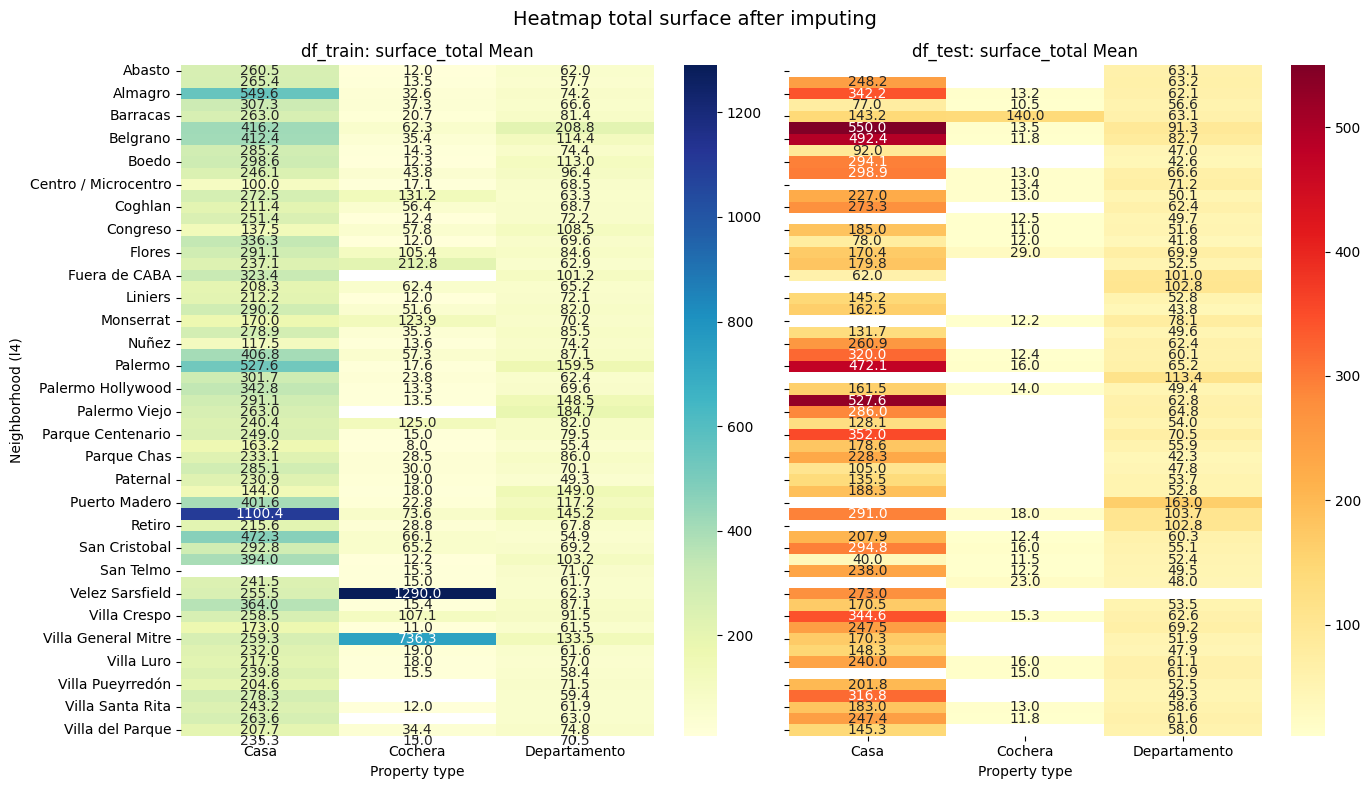

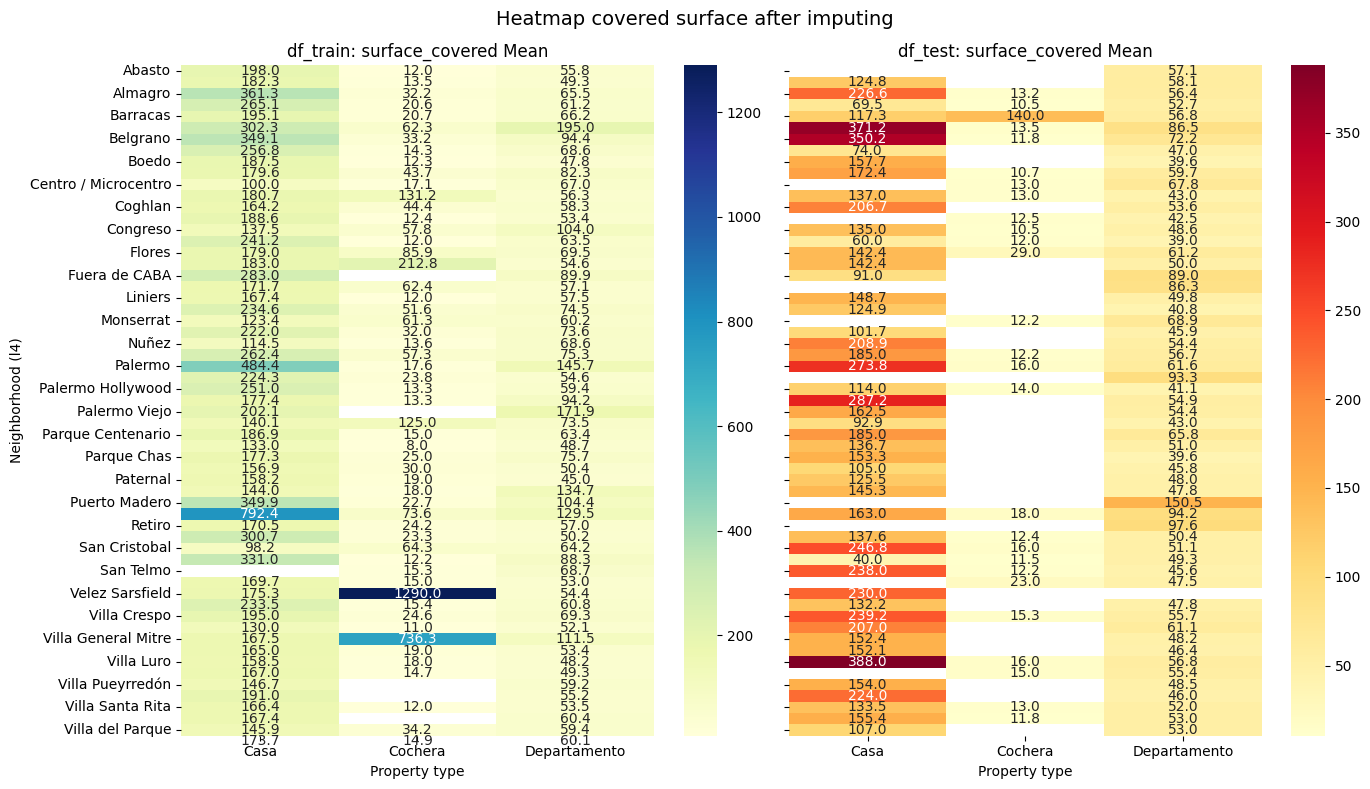

In [22]:
graficar_heatmaps(df_train, df_test, 'surface_total', titulo='Heatmap total surface after imputing')
graficar_heatmaps(df_train, df_test, 'surface_covered', titulo='Heatmap covered surface after imputing')

### Bathrooms imputation

* Garages do not have any
* Bathrooms as difference between rooms and bedrooms
* For studio apartments, there would be only one bathroom

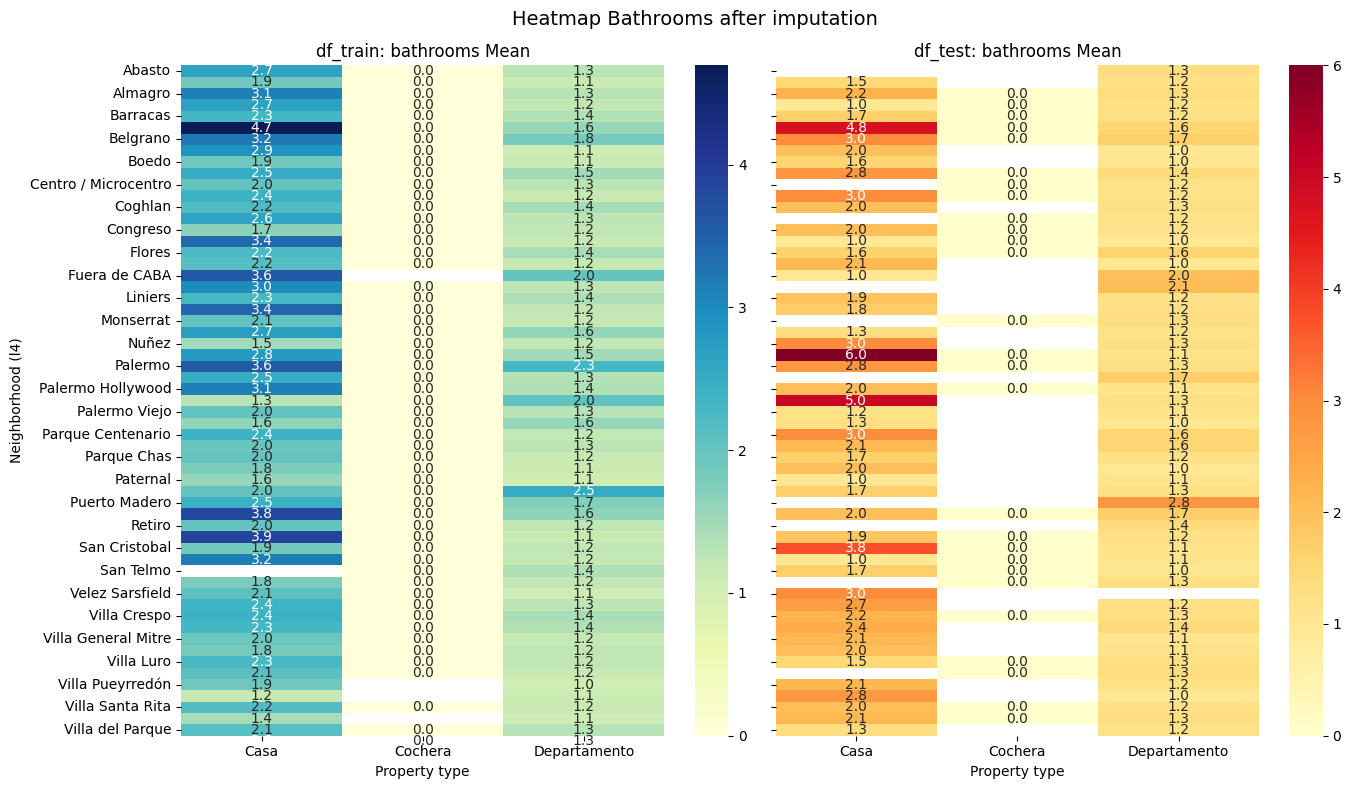

In [23]:
for df in [df_train, df_test]:
    df.loc[df['property_type'] == 'Cochera', ['bathrooms', 'rooms', 'bedrooms']] = 0
    df.loc[:, 'bathrooms'] = df['bathrooms'].fillna(df['rooms'] - df['bedrooms'])
    df.loc[(df['rooms'] == 1) & (df['bathrooms'].isna()), 'bathrooms'] = 1

graficar_heatmaps(df_train, df_test, 'bathrooms', 'Heatmap Bathrooms after imputation')

### Rooms and bedrooms

* Impute based on the other category adding or substracting one.

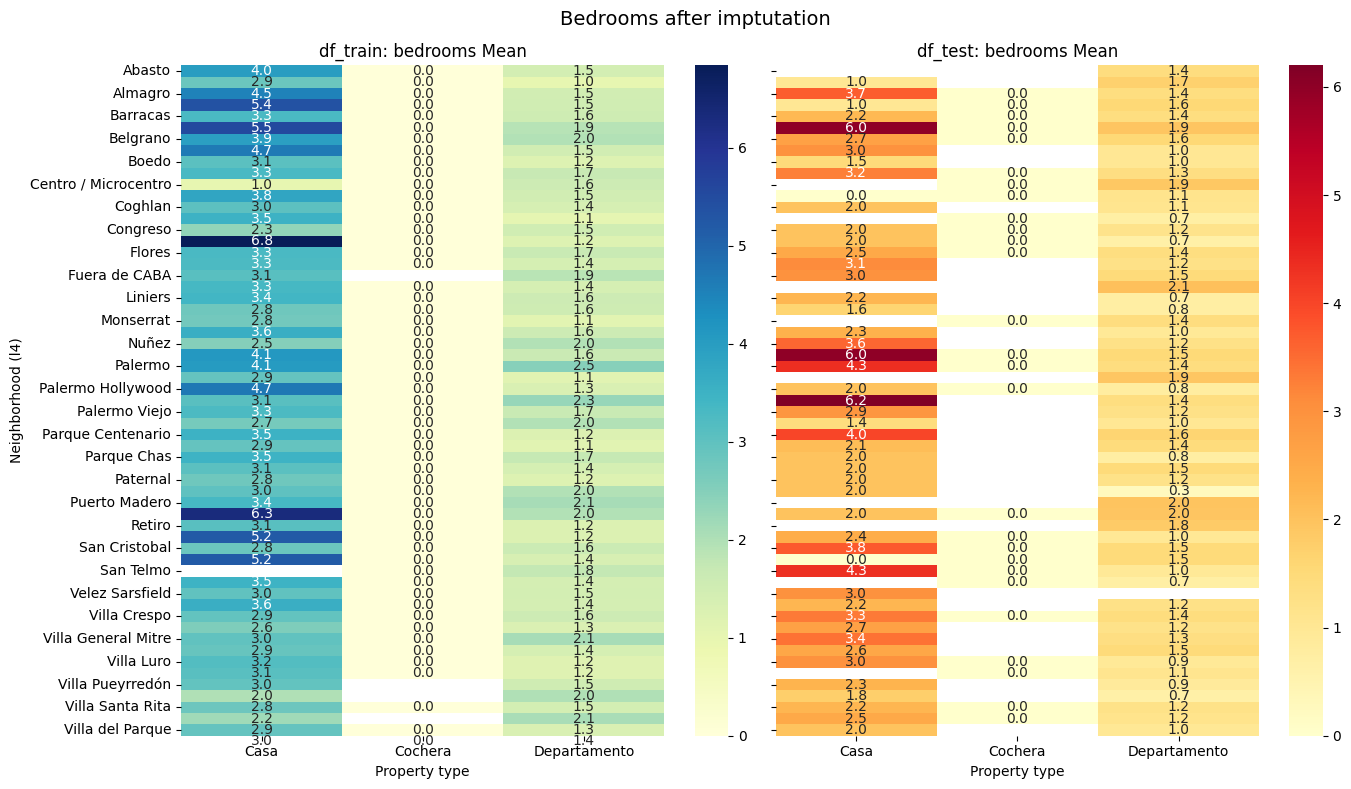

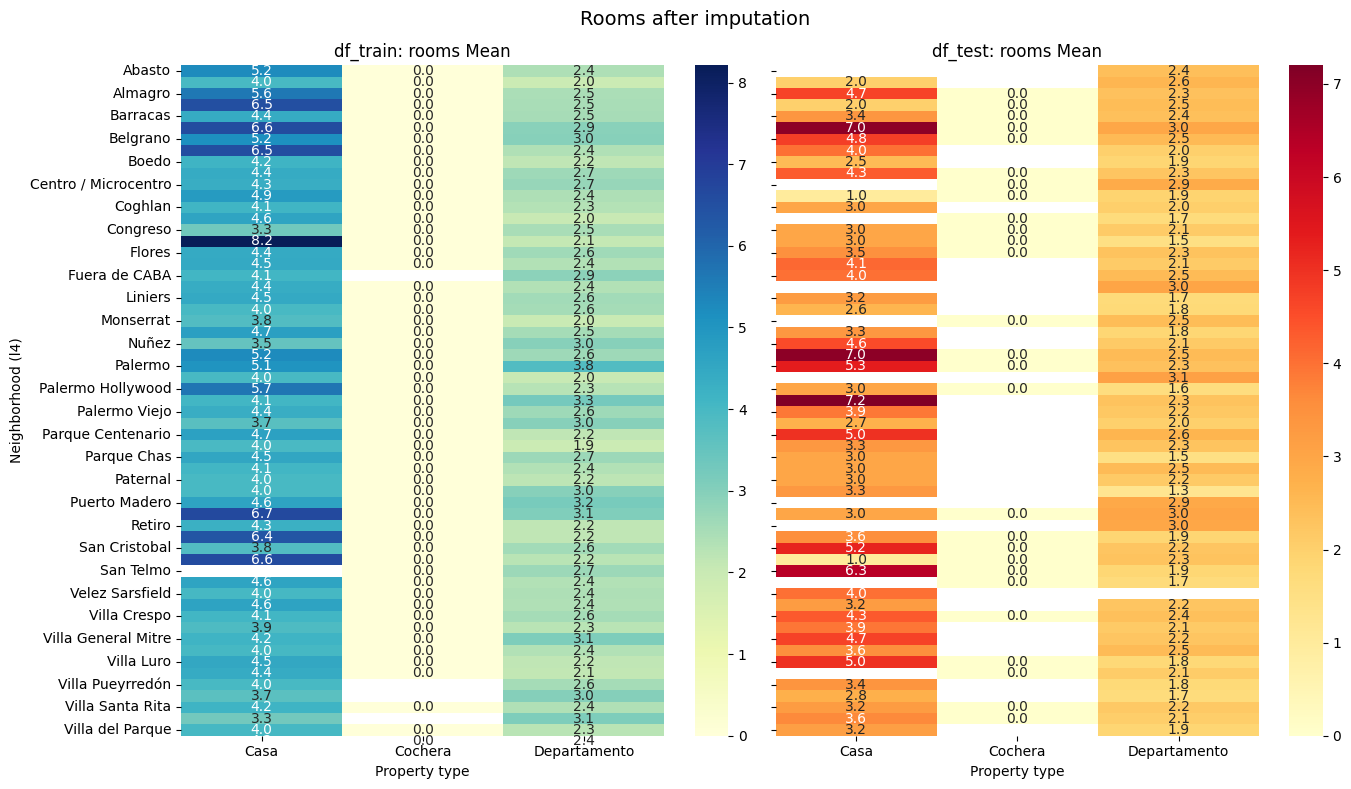

In [24]:
for df in [df_train, df_test]:
    df.loc[:, 'bedrooms'] = df['bedrooms'].fillna(df['rooms'] - 1)
    df.loc[:, 'rooms'] = df['rooms'].fillna(df['bedrooms'] + 1)

graficar_heatmaps(df_train, df_test, 'bedrooms', 'Bedrooms after imptutation')
graficar_heatmaps(df_train, df_test, 'rooms', 'Rooms after imputation')

### Sanity Check

* Filter out registers that have null `total_surface` or price as these variables are highly important for determining property's price.

In [25]:
for df in [df_train]:
    df = df.loc[df['price'].isna() | df['surface_total'].notna()]

### Sanity check

* Are prices within range?

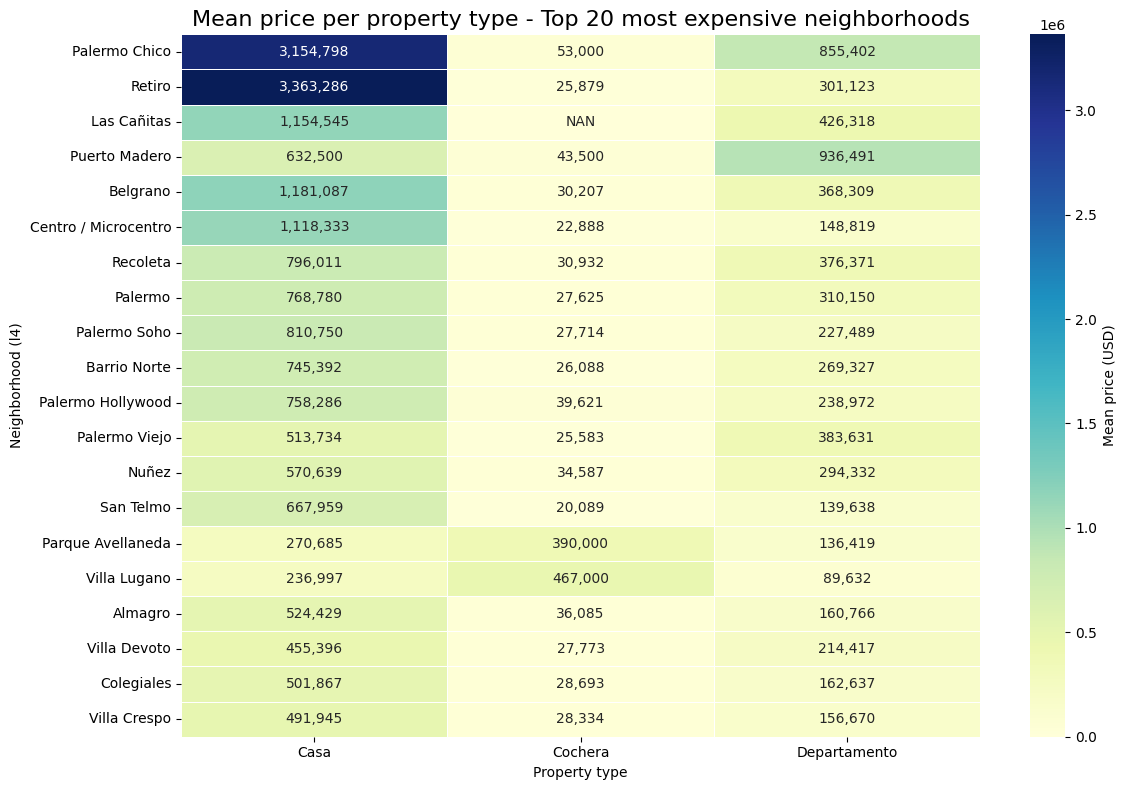

In [26]:
def heatmap_precio_medio_top20(df, titulo='Mean price per property type - Top 20 most expensive neighborhoods'):
   #Plots top20 most expensive districts
    matrix = df.pivot_table(index='l4', columns='property_type', values='price', aggfunc='mean')

    top20_index = matrix.mean(axis=1).sort_values(ascending=False).head(20).index
    matrix = matrix.loc[top20_index]

    labels = matrix.copy().astype(object)
    for row in labels.index:
        for col in labels.columns:
            val = labels.loc[row, col]
            labels.loc[row, col] = f'{val:,.0f}' if pd.notna(val) else 'NAN'

    matrix_filled = matrix.fillna(0)
    plt.figure(figsize=(12, len(matrix) * 0.4))
    sns.heatmap(matrix_filled, cmap='YlGnBu', annot=labels, fmt='', linewidths=0.5, cbar_kws={'label': 'Mean price (USD)'})
    plt.title(titulo, fontsize=16)
    plt.xlabel('Property type')
    plt.ylabel('Neighborhood (l4)')
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

heatmap_precio_medio_top20(df_train)

### Use of external data

* Using external data to check which neighborhoods are in fact the most expensive ones.
* External data:  `Zona prop, January 2020`.


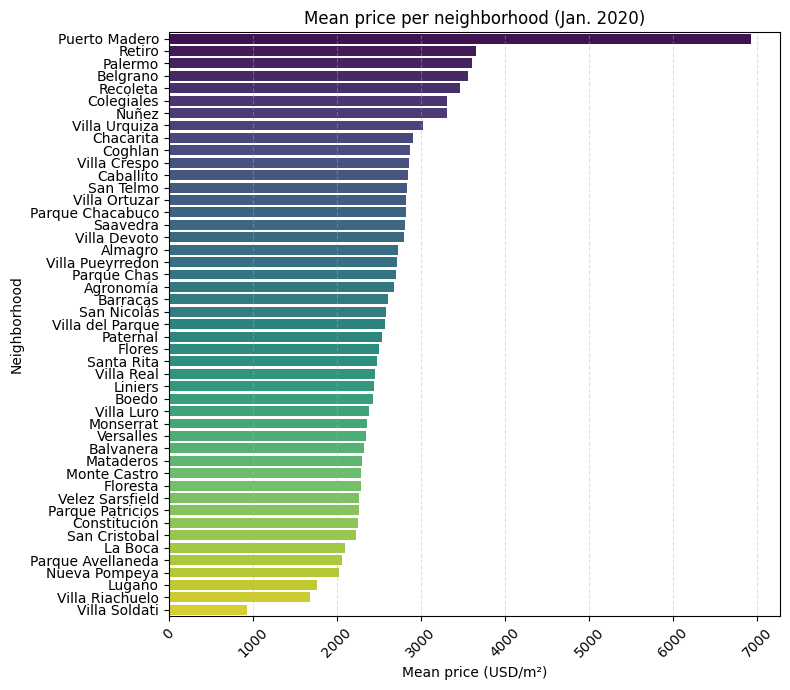

In [27]:
df = pd.read_csv(f"{DIR}/precios_ref_ZP_Ene2020.csv")
df = df.replace("-", np.nan)
cols_num = ["ESTRENAR", "POZO", "USADO"]
df[cols_num] = df[cols_num].astype(float)
if "INDEX" in df.columns:
    df = df.drop(columns=["INDEX"])
df["PROMEDIO"] = df[cols_num].mean(axis=1)

df_sorted = df.sort_values(by="PROMEDIO", ascending=False)

plt.figure(figsize=(8, 7))
sns.barplot(data=df_sorted, y="BARRIO", x="PROMEDIO", palette="viridis")
plt.title("Mean price per neighborhood (Jan. 2020)")
plt.xlabel("Mean price (USD/m²)")
plt.ylabel("Neighborhood")
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

* Puerto Madero, Retiro, and Palermo are the most expensive neighborhoods
* Maximum price filter: 2 million dollars per property, unless the neighborhood is one of these
* I found this threshold through iteration


In [28]:
umbral = 2000000
barrios_excepcionales = ["Puerto Madero", "Retiro", "Palermo", "Palermo Viejo" , "Palermo Soho", "Palermo Chico"]
es_barrio_valido = df_train['l4'].str.lower().str.contains('palermo') | df_train['l4'].isin(barrios_excepcionales)
df_train = df_train[~((df_train['price'] > umbral) & (~es_barrio_valido))]

* Calculation of internal price per squared meter and creation of a statistic in order to filter possible outliers.

In [29]:
df_train["price_m2_interno"] = df_train["price"] / (df_train["surface_total"] + 0.001)
df_train = df_train[(df_train['price_m2_interno'] >= 500) & (df_train['price_m2_interno'] <= 10000) ]
df_train = df_train[~((df_train['price_m2_interno'] > 5000) & (df_train['l4'] != 'Puerto Madero'))]
#-------
df_train_aux = df_train.copy()
df_train_aux = df_train_aux[df_train_aux['price'] <= 2000000]
gb = df_train_aux.groupby(by=["property_type", "l4"])["price_m2_interno"].mean().reset_index()
gb.rename(columns={"price_m2_interno":"price_m2_estad"}, inplace=True)

idx_original = df_train.index
df_train = df_train.merge(gb[['l4', 'property_type', 'price_m2_estad']], on=['l4', 'property_type'],how='left')
df_train.index = idx_original

df_train["price_m2_x_surface_total"] = df_train["price_m2_estad"] * df_train["surface_total"]

filtro =  (df_train["price_m2_interno"] - df_train['price_m2_estad'] ) > 1000
df_train = df_train[~ filtro]

original_idx = df_test.index
df_test = df_test.merge(gb[['l4', 'property_type', 'price_m2_estad']], on=['l4', 'property_type'],how='left')
df_test.index = original_idx
df_test["price_m2_x_surface_total"] = df_test["price_m2_estad"] * df_test["surface_total"]
df_train = df_train.drop(columns=['price_m2_interno'])

### Remaining NaNs

* Imputing remaining NaNs based on median of `group_cols = [l4, bedrooms, bathrooms]`

In [30]:
df_train['particion'] = 'TRAIN'
df_test['particion'] = 'TEST'
df_total = pd.concat([df_train, df_test], ignore_index=True)

In [31]:
def imputar_mediana(df, target_col, group_cols):
  #Used to impute a target column using the median method.
    df = df.copy()
    original_index = df.index
    medianas = (df.groupby(group_cols)[target_col].median().round().astype('Int64')
                  .reset_index().rename(columns={target_col: f"mediana_{target_col}"}))
    df = df.merge(medianas, on=group_cols, how='left'); df.index = original_index
    df[target_col] = df[target_col].fillna(df[f"mediana_{target_col}"])
    df.drop(columns=[f"mediana_{target_col}"], inplace=True)
    print(f"🔍 '{target_col}': {df[target_col].isna().sum()} Remaining missing values")
    return df

df_total = imputar_mediana(df_total, 'bathrooms', ['l4', 'rooms', 'bedrooms'])
df_total = imputar_mediana(df_total, 'rooms', ['l4', 'bedrooms', 'bathrooms'])
df_total = imputar_mediana(df_total, 'bedrooms', ['bathrooms', 'rooms', 'l4'])

🔍 'bathrooms': 396 Remaining missing values
🔍 'rooms': 1672 Remaining missing values
🔍 'bedrooms': 1672 Remaining missing values


### Text mining

New feature creation by text mining the `descripcion` field.

* Security
* Amenities
* Luxurious features
* New/used
* Mortgage-eligible
* Suitable for professional use

In [32]:
palabras_seguridad = ['seguridad', 'totem', 'camara', 'cámaras', 'camaras', 'cámara', 'portero', 'portero eléctrico', 'portero digital', 'vigilancia', 'vigilador', 'vigilado', 'guardia', 'guardias', 'alarma', 'monitoreo', 'monitoreada', '24h', '24hs', '24 horas', 'seguridad privada', 'custodia', 'control de acceso', 'acceso controlado', 'llave electrónica', 'llavero magnético', 'circuito cerrado', 'cctv', 'cerco eléctrico', 'rejas', 'blindaje', 'seguro']
palabras_otros_amenities = ['losa radiante', 'calefacción por losa radiante', 'lavadero', 'laundry', 'lavandería', 'ascensor', 'ascensores', 'caldera', 'calefaccion', 'calefacción', 'sistema de calefacción', 'lavanderia', 'lavadero independiente', 'jacuzzi', 'jacuzi', 'yacuzi', 'yacuzzi', 'yacusi', 'jacusi', 'parrilla', 'parrillero', 'asador', 'quincho', 'sum', 's.u.m.', 'salon de usos multiples', 'salón de usos múltiples', 'salón usos múltiples', 'salon usos multiples', 'salón de usos', 'SUM', 'salon de usos', 'solarium', 'solárium', 'pileta', 'piscina', 'alberca', 'piletón', 'piscinas']
palabras_lujo = ['marmol', 'mármol', 'roble', 'penthouse']

palabras_pozo = ['pozo', 'de pozo', 'poso', 'en construcción', 'en construccion','a estrenar', 'estrenar', 'nuevo', 'nueva']
palabras_usado = ['usada', 'usado', 'reciclado', 'recientemente reciclado', 'reacondicionado', 'reacondicionada','reciclada', 'reformada', 'remodelado', 'remodelada', 'a nuevo', 'recién pintado', 'recien pintado','reformar', 'a reformar', 'refaccionar', 'a refaccionar']

palabras_credito = [r'\bapto credito\b', r'\bapto crédito\b', r'\bcrédito\b', r'\bcredito\b']
palabras_profesional = [r'\bapto profesional\b', r'\bprofesional\b']

def contar_apariciones(df, columna_texto, lista_palabras, nombre_columna_salida):
    #Counts appearances of words in a list, used for text mining
    patron = r'\b(?:' + '|'.join([re.escape(p) for p in lista_palabras]) + r')\b'
    df[nombre_columna_salida] = df[columna_texto].str.count(patron, flags=re.IGNORECASE).fillna(0).astype(int)
    return df

df_total = contar_apariciones(df_total, 'description', palabras_seguridad, 'seguridad')
df_total = contar_apariciones(df_total, 'description', palabras_otros_amenities, 'otros_amenities')
df_total = contar_apariciones(df_total, 'description', palabras_lujo, 'lujo')
df_total = contar_apariciones(df_total, 'description', palabras_pozo, 'pozo')
df_total = contar_apariciones(df_total, 'description', palabras_usado, 'usado')
df_total = contar_apariciones(df_total, 'description', palabras_credito, 'credito')
df_total = contar_apariciones(df_total, 'description', palabras_profesional, 'profesional')

In [33]:
df_train = df_total[df_total['particion'] == 'TRAIN'].copy()
df_test  = df_total[df_total['particion'] == 'TEST'].copy()
df_train.drop(columns='particion', inplace=True)
df_test.drop(columns='particion', inplace=True)

### Remainin NaNs

* Filling remaining NaNs in the dataset wtih 0's per ML model to use requirements.

In [34]:
def resumen_nans(df, nombre_df):
    # Summary of NaNs per column, displays the column, the number of NaNs and the % they represent
    total = df.shape[0]
    resumen = pd.DataFrame({
        'column': df.columns,
        'n_nan': df.isna().sum().values,
        '%_nan': (df.isna().sum().values / total * 100).round(2)
    })
    resumen = resumen[resumen['n_nan'] > 0].sort_values('n_nan', ascending=False).reset_index(drop=True)
    print(f"\n📊 NaNs in {nombre_df}:\n")
    print(resumen)
    return resumen

# Aplicar a cada dataset
resumen_nans(df_train, 'df_train')
resumen_nans(df_test, 'df_test')

df_train[df_train.select_dtypes(include='number').columns] = df_train.select_dtypes(include='number').fillna(0)
df_test[df_test.select_dtypes(include='number').columns] = df_test.select_dtypes(include='number').fillna(0)


📊 NaNs in df_train:

         column  n_nan   %_nan
0            l5  79200  100.00
1            l6  79200  100.00
2  price_period  48629   61.40
3           lat   3748    4.73
4           lon   3714    4.69
5         rooms   1413    1.78
6      bedrooms   1413    1.78
7     bathrooms    350    0.44
8         title     10    0.01

📊 NaNs in df_test:

                      column  n_nan   %_nan
0                         l5   7012  100.00
1                      price   7012  100.00
2               price_period   7012  100.00
3                         l6   7012  100.00
4                        lat    471    6.72
5                        lon    471    6.72
6                   bedrooms    259    3.69
7                      rooms    259    3.69
8                  bathrooms     46    0.66
9                         l3      8    0.11
10            price_m2_estad      3    0.04
11  price_m2_x_surface_total      3    0.04


### Georeferencing

* Exchange `lon` and `lat` columns, as these were mixed in the original data frame.
* Use of spatial information to create new predictive variables.

In [35]:
shapefile_path = f"{DIR}/neighborhoods/barrios.shp" # Source: https://data.buenosaires.gob.ar/dataset/barrios
city_gdf = gpd.read_file(shapefile_path)
if city_gdf.crs != "EPSG:4326":
    city_gdf = city_gdf.to_crs("EPSG:4326")

df_train = df_train.rename(columns={'lon': 'temp', 'lat': 'lon'})
df_train = df_train.rename(columns={'temp': 'lat'})

df_test = df_test.rename(columns={'lon': 'temp', 'lat': 'lon'})
df_test = df_test.rename(columns={'temp': 'lat'})

Plotting the location of the properties in CABA.

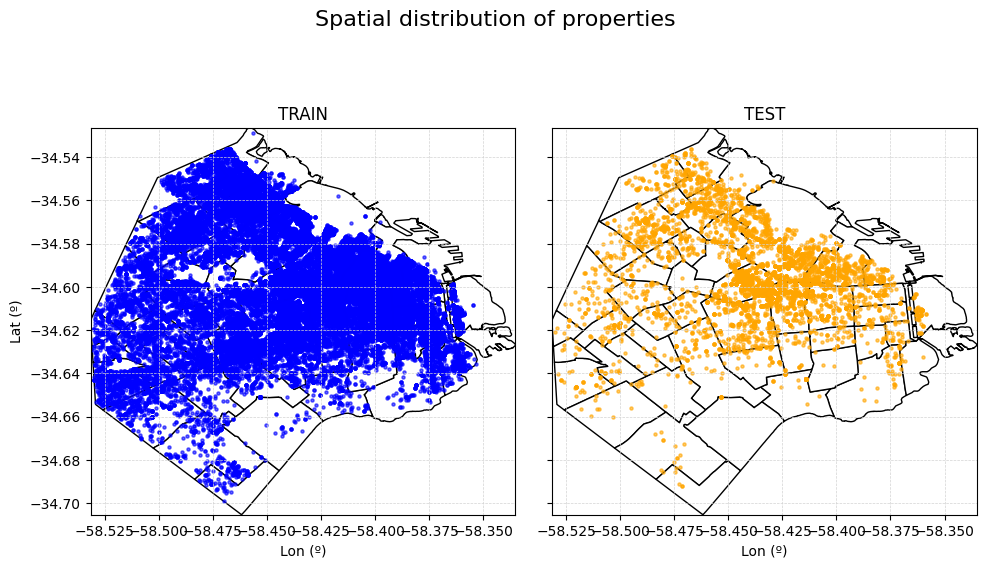

In [36]:
gdf_train = gpd.GeoDataFrame(df_train.copy(), geometry=gpd.points_from_xy(df_train.lon, df_train.lat), crs="EPSG:4326")
gdf_test  = gpd.GeoDataFrame(df_test.copy(),  geometry=gpd.points_from_xy(df_test.lon,  df_test.lat),  crs="EPSG:4326")

xmin, ymin, xmax, ymax = city_gdf.total_bounds

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle('Spatial distribution of properties', fontsize=16)
city_gdf.plot(ax=ax1, color='white', edgecolor='black')
city_gdf.plot(ax=ax2, color='white', edgecolor='black')

gdf_train.plot(ax=ax1, markersize=5, color='blue', alpha=0.6)
ax1.set_title('TRAIN')
ax1.set_xlabel('Lon (º)')
ax1.set_ylabel('Lat (º)')

gdf_test.plot(ax=ax2, markersize=5, color='orange', alpha=0.6)
ax2.set_title('TEST')
ax2.set_xlabel('Lon (º)')

for ax in [ax1, ax2]:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Properties outside CABA?

* Since I want to keep the number of rows to be predicted in `a_predecir.csv` I won't delete the row if I find any proipoerty outside CABA.
* I decided to give more weight to `L4` than to `lon`/`lat`, but it's still something to keep in mind.

In [37]:
city_gdf = gpd.read_file(shapefile_path)
if city_gdf.crs != "EPSG:4326":
    city_gdf = city_gdf.to_crs("EPSG:4326")

caba_polygon = city_gdf.union_all()

gdf_train = gpd.GeoDataFrame(df_train.copy(),
                             geometry=gpd.points_from_xy(df_train.lon, df_train.lat),
                             crs="EPSG:4326")

gdf_test = gpd.GeoDataFrame(df_test.copy(),
                            geometry=gpd.points_from_xy(df_test.lon, df_test.lat),
                            crs="EPSG:4326")

gdf_train['in_caba'] = gdf_train.geometry.within(caba_polygon)
gdf_test['in_caba'] = gdf_test.geometry.within(caba_polygon)

print("✅ TRAIN: within CABA =", gdf_train['in_caba'].sum(), ", ❌ outside CABA =", (~gdf_train['in_caba']).sum())
print("✅ TEST: within CABA =", gdf_test['in_caba'].sum(), ", ❌ outside CABA =", (~gdf_test['in_caba']).sum())

✅ TRAIN: within CABA = 75438 , ❌ outside CABA = 3762
✅ TEST: within CABA = 6539 , ❌ outside CABA = 473


### Distance to hot spots in CABA

In [38]:
def haversine_np(lat1, lon1, lat2, lon2):
    #Distance calculation, in km, using the Haversine formula
    R = 6371  # R earth, km
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat/2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def agregar_distancias(df, lugares_dict, prefix='dist'):
    df = df.copy()
    for nombre, (lat_ref, lon_ref) in lugares_dict.items():
        nombre_col = f"{prefix}_{nombre.lower().replace(' ', '_').replace('-', '_')}"
        df[nombre_col] = haversine_np(df['lat'], df['lon'], lat_ref, lon_ref)
    return df

lugares = {
    "Cabildo y Juramento": (-34.562005, -58.456720),
    "Santa Fe y Callao": (-34.595337, -58.395405),
    "Callao y Corrientes": (-34.604013, -58.392763),
    "Nazca y Avellaneda": (-34.617868, -58.484329),
    "Obelisco": (-34.6037389, -58.3815704),
    "Museo Nacional de Bellas Artes": (-34.583154, -58.392899),
    "Villa 31": (-34.583800, -58.383800),
    "Villa 1-11-14": (-34.633400, -58.430000),
    "Villa 21-24": (-34.653300, -58.377100),
    "Estadio River": (-34.545369, -58.449943),
    "Estadio Boca": (-34.635611, -58.364611)}

df_train = agregar_distancias(df_train, lugares)
df_test = agregar_distancias(df_test, lugares)

### Distance to hospitals and parks

* Obs: the same logic could be applied for distances to bus/metro stations accounting for the minimum distance to any of those, or the number of stops within ranges of 0.2km, 0.5km, 0.8km, etc.



In [39]:
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    return R * 2 * np.arcsin(np.sqrt(a))

def distancia_minima(lat_series, lon_series, ref_lats, ref_lons):
    return pd.Series([
        np.min(haversine_np(lat, lon, ref_lats, ref_lons)) if not pd.isna(lat) and not pd.isna(lon) else np.nan
        for lat, lon in zip(lat_series, lon_series)
    ], index=lat_series.index)

def extraer_lat_lon_desde_geometria(gseries):
    centroides = gseries.centroid
    return centroides.y.values, centroides.x.values

#Hospitals
gdf_hospitals = gpd.read_file(f"{DIR}/hospitals/hospitales.shp")
gdf_hospitals = gdf_hospitals[~gdf_hospitals.geometry.is_empty]
if gdf_hospitals.crs != "EPSG:4326":
    gdf_hospitals = gdf_hospitals.to_crs(epsg=4326)
hospital_lats, hospital_lons = extraer_lat_lon_desde_geometria(gdf_hospitals.geometry)

# Parks
gdf_parques = gpd.read_file(f"{DIR}/parks/espacio_verde_publico.shp")
gdf_parques = gdf_parques[~gdf_parques.geometry.is_empty]
if gdf_parques.crs != "EPSG:4326":
    gdf_parques = gdf_parques.to_crs(epsg=4326)
parque_lats, parque_lons = extraer_lat_lon_desde_geometria(gdf_parques.geometry)

df_train['dist_hospital_mas_cercano'] = distancia_minima(df_train['lat'], df_train['lon'], hospital_lats, hospital_lons)
df_train['dist_parque_mas_cercano'] = distancia_minima(df_train['lat'], df_train['lon'], parque_lats, parque_lons)
df_test['dist_hospital_mas_cercano'] = distancia_minima(df_test['lat'], df_test['lon'], hospital_lats, hospital_lons)
df_test['dist_parque_mas_cercano'] = distancia_minima(df_test['lat'], df_test['lon'], parque_lats, parque_lons)

columnas_a_eliminar = ['price_period', 'l3', 'l5', 'l6']
df_train = df_train.drop(columns=columnas_a_eliminar, errors='ignore')
df_test = df_test.drop(columns=columnas_a_eliminar, errors='ignore')

### Categorical variables as dummies

* Per requirements of the ML models to use, no categorical variable would be included.
* Therefore interesting variables such as `l4` and `propoerty_type` are converted to dummies.

In [40]:
# Property_type
df_train = pd.get_dummies(df_train, columns=['property_type'], prefix='prop', dtype=int)
df_test = pd.get_dummies(df_test, columns=['property_type'], prefix='prop', dtype=int)

# L4
df_train_dummies = pd.get_dummies(df_train['l4'], prefix='l4', dtype=int)
df_train = pd.concat([df_train.drop('l4', axis=1), df_train_dummies], axis=1)

df_test_dummies = pd.get_dummies(df_test['l4'], prefix='l4', dtype=int)

df_test_dummies = df_test_dummies.reindex(columns=df_train_dummies.columns, fill_value=0)
df_test = pd.concat([df_test.drop('l4', axis=1), df_test_dummies], axis=1)

train_cols = set(df_train_dummies.columns)
test_cols = set(df_test_dummies.columns)

if train_cols == test_cols:
    print("✅ df_train and df_test have the same l4 dummy columns")
else:
    print("❌ Differences found in l4 dummy columns between df_train and df_test")
    print("In df_train but not in df_test:", train_cols - test_cols)
    print("In df_test but not in df_train:", test_cols - train_cols)

resumen_nans(df_train, 'df_train')
resumen_nans(df_test, 'df_test')

# Used un error analysis
df_train_antes_ajuste = df_train.copy()
df_test_antes_ajuste = df_test.copy()

✅ df_train and df_test have the same l4 dummy columns

📊 NaNs in df_train:

  column  n_nan  %_nan
0  title     10   0.01

📊 NaNs in df_test:

Empty DataFrame
Columns: [column, n_nan, %_nan]
Index: []


### Sanity check

* Checking variable distribution before applying ML models.

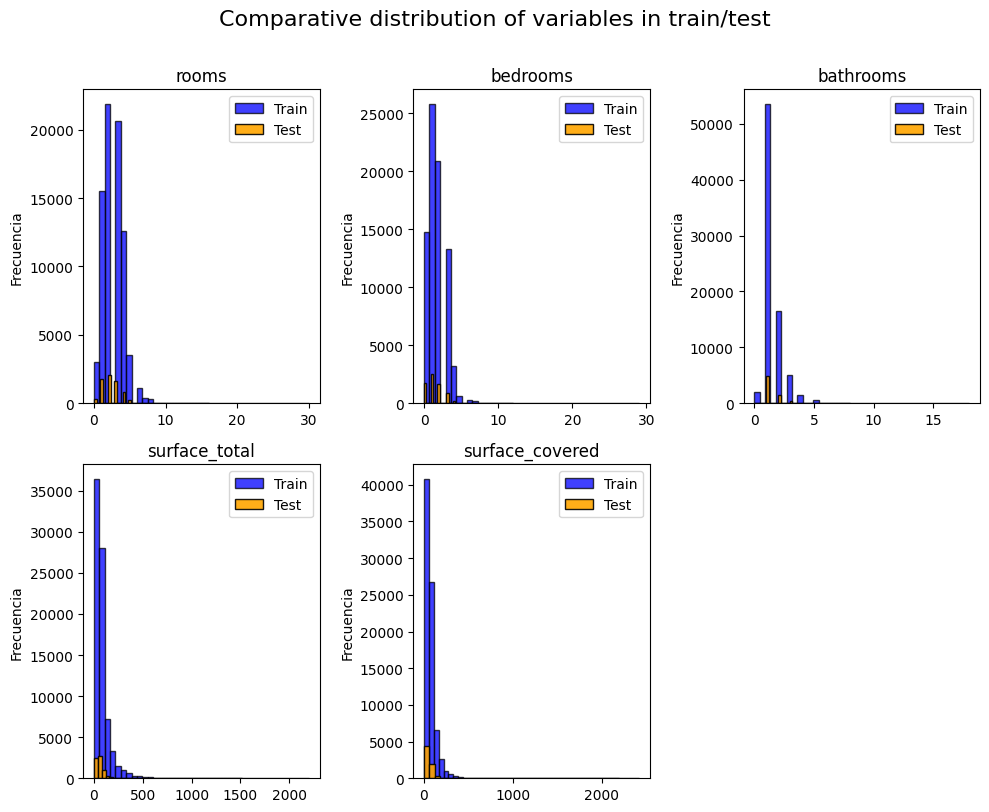

In [41]:
cols = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

n = len(cols)
rows = (n + 2) // 3
plt.figure(figsize=(10, 4 * rows))

for i, col in enumerate(cols, 1):
    plt.subplot(rows, 3, i)
    plt.hist(df_train[col].dropna(), bins=40, alpha=0.75, label='Train', color='blue', edgecolor='black')
    plt.hist(df_test[col].dropna(), bins=40, alpha=0.9, label='Test',color='orange', edgecolor='black')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Frecuencia')
    plt.legend()

plt.suptitle('Comparative distribution of variables in train/test', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

* Display each property in `df_train` as a round point, colored according to its price value.
* Display the polygon of each neighborhood, colored based on the average price of the properties within that neighborhood (using `df_train`).


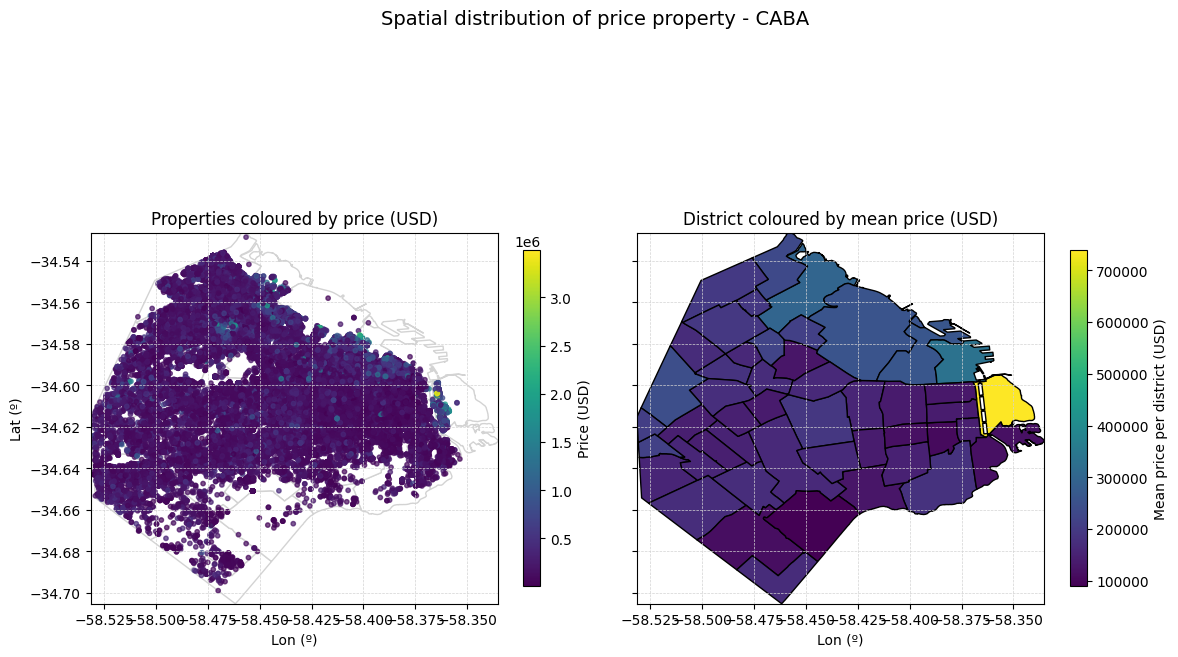

In [42]:
geometry = [Point(xy) for xy in zip(df_train['lon'], df_train['lat'])]
gdf_train = gpd.GeoDataFrame(df_train, geometry=geometry, crs="EPSG:4326")

if city_gdf.crs != "EPSG:4326":
    city_gdf = city_gdf.to_crs("EPSG:4326")

gdf_train = gpd.sjoin(gdf_train, city_gdf[['nombre', 'geometry']], how='left', predicate='within')

precio_medio_por_barrio = gdf_train.groupby('nombre')['price'].mean().reset_index()
precio_medio_por_barrio.columns = ['nombre', 'mean_price']

city_coloreado = city_gdf.merge(precio_medio_por_barrio, on='nombre', how='left')

xmin, ymin, xmax, ymax = city_gdf.total_bounds


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)
fig.suptitle("Spatial distribution of price property - CABA", fontsize=14)

#  Map 1
city_gdf.plot(ax=ax1, color='white', edgecolor='lightgray')
gdf_train.plot(
    ax=ax1,
    column='price',
    cmap='viridis',
    markersize=10,
    alpha=0.7,
    legend=True,
    legend_kwds={'label': "Price (USD)", 'shrink': 0.5}
)
ax1.set_title("Properties coloured by price (USD)")
ax1.set_xlabel("Lon (º)")
ax1.set_ylabel("Lat (º)")

# Map 2
city_coloreado.plot(
    ax=ax2,
    column='mean_price',
    cmap='viridis',
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Mean price per district (USD)", 'shrink': 0.5}
)
ax2.set_title("District coloured by mean price (USD)")
ax2.set_xlabel("Lon (º)")

for ax in [ax1, ax2]:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Training ML models and predicting

* Choice of Model: Random Forest Regressor. For this project, I selected the Random Forest Regressor as the predictive model. Random Forest is an ensemble learning method that builds multiple decision trees during training and outputs the average prediction of these trees.
* Train/test splitting of `df_train` dataset and information summary in `df_hiperparam`
* Commented code: used to grid search best hiperparameters

In [43]:
df_hiperparam = pd.DataFrame(columns=['Clasificador', 'Metodo' , 't_ejecucion_segs', 'n_estimator', 'max_depth',
                                        'min_samples_leaf' , 'min_samples_split',  'score_train', 'score_test' ,
                                        'best_score_test'])

df_train = df_train.select_dtypes(['number', 'bool'])
X = df_train[df_train.columns.drop('price')]
y = df_train['price']

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
best_score_test = 1000000

#### Grid search to find best hyperparameters

To optimize model performance, I used grid search to systematically explore combinations of hyperparameters such as:

* Number of trees (n_estimators)

* Maximum depth of each tree (max_depth)

* Minimum samples required to split a node (min_samples_split)

* Minimum samples required at a leaf node (min_samples_leaf)

Then the best combination is retained to fit the actual model.

In [44]:
'''
for N_ESTIMATOR in [300, 500]:
    for MAX_DEPTH  in [10, 20, 30, 50]:
        for MIN_SAMPLE_LEAF in [10, 20, 50]:
            for MIN_SAMPLE_SPLIT in [20,50]:
                modelo = "Random Forest"
                method = 'Train/test split'
                start_time = time.time()

                reg = sk.ensemble.RandomForestRegressor(n_estimators = N_ESTIMATOR, max_depth = MAX_DEPTH,
                                                        min_samples_leaf = MIN_SAMPLE_LEAF, min_samples_split = MIN_SAMPLE_SPLIT,
                                                        n_jobs = -1, random_state = 42)

                _ = reg.fit(X_train, y_train)


                y_pred = reg.predict(X_train)
                score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)

                y_pred = reg.predict(X_test)
                score_test  = sk.metrics.root_mean_squared_error(y_test, y_pred)

                best_score_test = min(best_score_test, score_test)

                end_time = time.time()

                df_hiperparam.loc[len(df_hiperparam)] = {
                        'Clasificador' : modelo,
                        'Metodo' : method,
                        't_ejecucion_segs': end_time - start_time,
                        'n_estimator': N_ESTIMATOR,
                        'max_depth': MAX_DEPTH,
                        'min_samples_leaf' : MIN_SAMPLE_LEAF,
                        'min_samples_split' : MIN_SAMPLE_SPLIT,
                        'score_train' : score_train,
                        'score_test' : score_test,
                        'best_score_test':best_score_test}
'''


'\nfor N_ESTIMATOR in [300, 500]:\n    for MAX_DEPTH  in [10, 20, 30, 50]:\n        for MIN_SAMPLE_LEAF in [10, 20, 50]:\n            for MIN_SAMPLE_SPLIT in [20,50]:\n                modelo = "Random Forest"\n                method = \'Train/test split\'\n                start_time = time.time()\n\n                reg = sk.ensemble.RandomForestRegressor(n_estimators = N_ESTIMATOR, max_depth = MAX_DEPTH,\n                                                        min_samples_leaf = MIN_SAMPLE_LEAF, min_samples_split = MIN_SAMPLE_SPLIT,\n                                                        n_jobs = -1, random_state = 42)\n\n                _ = reg.fit(X_train, y_train)\n\n\n                y_pred = reg.predict(X_train)\n                score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)\n\n                y_pred = reg.predict(X_test)\n                score_test  = sk.metrics.root_mean_squared_error(y_test, y_pred)\n\n                best_score_test = min(best_score_test, s

Obs: Future upgrades:

* Use Cross Validation
* Use other type of algorithm like GradientBoosting.

#### Training the model with best hyperparameters

* Error metric: I used the Root Mean Squared Error (RMSE) metric to evaluate the model’s accuracy.
* RMSE measures the average magnitude of the prediction errors, expressed in the same units as the target variable (property's price)
* Interpretation:

  - A lower RMSE indicates better predictive accuracy.

  - RMSE is sensitive to large errors, so it penalizes models that occasionally make big mistakes.

In [45]:
N_ESTIMATOR = 500
MAX_DEPTH = 50
MIN_SAMPLE_LEAF = 10
MIN_SAMPLE_SPLIT =  20

start_time = time.time()
reg = sk.ensemble.RandomForestRegressor(n_estimators = N_ESTIMATOR, max_depth = MAX_DEPTH,
                                        min_samples_leaf = MIN_SAMPLE_LEAF, min_samples_split = MIN_SAMPLE_SPLIT,
                                        n_jobs = -1, random_state = 42)

_ = reg.fit(X_train, y_train)

y_pred = reg.predict(X_train)
score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)

y_pred = reg.predict(X_test)
score_test  = sk.metrics.root_mean_squared_error(y_test, y_pred)
best_score_test = min(best_score_test, score_test)
end_time = time.time()
print(f"\n\n->  📈 Score train: {round(score_train,3)}  \n->  🎯 Score test: {round(score_test,3)} \n\n  ")



->  📈 Score train: 38797.544  
->  🎯 Score test: 51958.649 

  


#### Variable importance

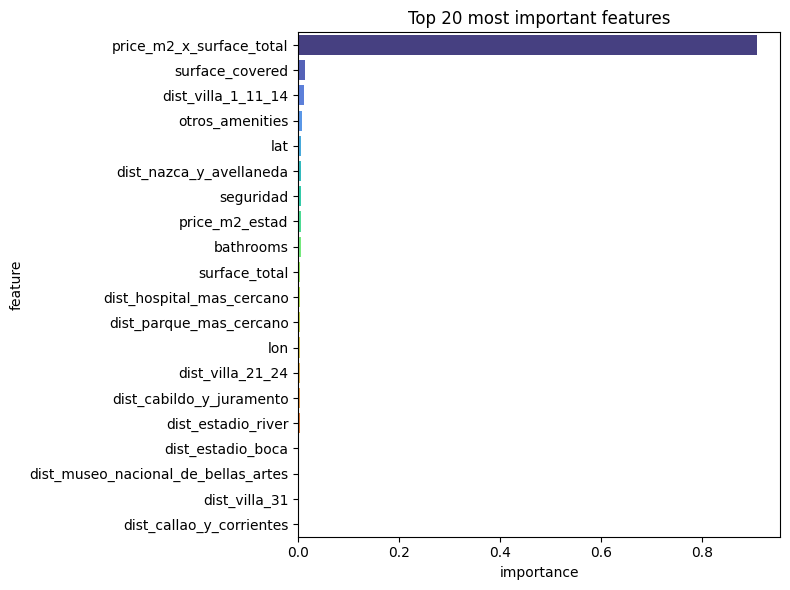

In [46]:
X = df_train[df_train.columns.drop('price')]
y = df_train['price']

reg = sk.ensemble.RandomForestRegressor(n_estimators=N_ESTIMATOR, max_depth=MAX_DEPTH,
                                        min_samples_leaf= MIN_SAMPLE_LEAF,
                                        min_samples_split = MIN_SAMPLE_SPLIT,
                                        n_jobs=-1, random_state=42)
_ = reg.fit(X, y)
pd.DataFrame({"importance": reg.feature_importances_}, index=X.columns).sort_values(by="importance", ascending=False)
df_imp = pd.DataFrame({"feature": X_train.columns,"importance": reg.feature_importances_}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x="importance", y="feature", data=df_imp, palette="turbo")
plt.title("Top 20 most important features")
plt.tight_layout()
plt.show()

#### Error analysis

* Top errors: I identified data points with the largest absolute prediction errors. Investigating these cases helps to understand where the model struggles the most — for example, unusual properties or data quality issues.
* Error-atribute correlation: by analyzing the relationship between prediction errors and specific features or columns, patterns may be detected such as systematic underestimation or overestimation for certain property types, neighborhoods or price ranges.
* Datapoints + error: plotting individual datapoints alongside their corresponding errors provides a spatial or feature-based perspective on model accuracy.
* Plotting the error as a way to analyze the model's performance: this visualization allows to evaluate if errors are randomly distributed or if there are clusters indicating potential model weaknesses.

             lon        lat  rooms  bedrooms  bathrooms  surface_total  \
7134  -58.447903 -34.571438    4.0       3.0        2.0         1069.0   
18348 -58.475514 -34.588534    0.0       0.0        0.0         1315.0   
14108 -58.374955 -34.604541    0.0       0.0        0.0         2200.0   
16252 -58.382917 -34.614547    0.0       0.0        0.0          605.0   
19802 -58.421180 -34.591555   26.0      25.0        1.0          820.0   
28809 -58.450777 -34.562601    6.0       5.0        3.0          316.5   
54370 -58.423530 -34.618906    6.0       3.0        5.0          509.0   
37006 -58.472737 -34.563922    7.0       6.0        3.0          450.0   
61366   0.000000   0.000000    4.0       3.0        3.0          290.0   
63650 -58.437859 -34.580073    5.0       4.0        2.0          240.0   
72626 -58.448759 -34.561757    6.0       5.0        2.0          316.5   
66563   0.000000   0.000000    4.0       3.0        4.0          186.0   
20130 -58.438501 -34.552132    6.0    

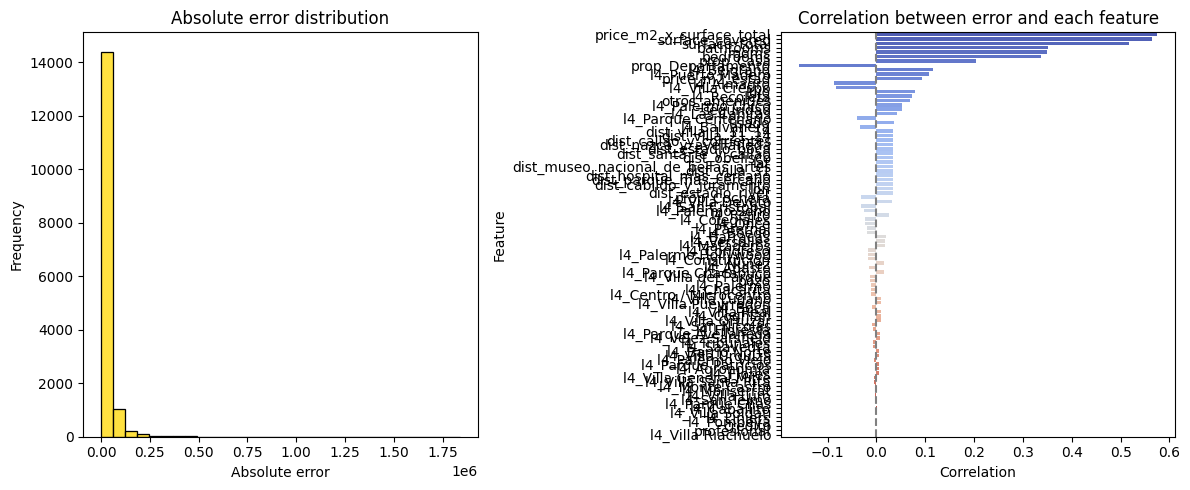

In [47]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

reg = sk.ensemble.RandomForestRegressor(n_estimators=N_ESTIMATOR, max_depth=MAX_DEPTH,
                                        min_samples_leaf= MIN_SAMPLE_LEAF,
                                        min_samples_split = MIN_SAMPLE_SPLIT,
                                        n_jobs=-1, random_state=42)
_ = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

X_test["error"] = abs(y_pred - y_test)
X_test["price"] = y_test
X_test["pred_price"] = y_pred
analisisDeErrores = X_test.sort_values(by="error", ascending=False)

# Top errors
top_errores = analisisDeErrores.head(20)
print(top_errores)

#Error-atribute correlation
for col in X_test.columns:
    if col not in ["error", "price", "pred_price"]:
        correlation = X_test["error"].corr(X_test[col])
        print(f"Correlation between error and {col}: {correlation:.2f}")


correlaciones = []
for col in X_test.columns:
    if col not in ["error", "price", "pred_price"]:
        corr = X_test["error"].corr(X_test[col])
        correlaciones.append((col, corr))

df_corr = pd.DataFrame(correlaciones, columns=["feature", "correlation"])
df_corr = df_corr.sort_values(by="correlation", key=abs, ascending=False)


# Datapoints + error
df_err = df_train_antes_ajuste.loc[top_errores.index]
df_err = df_err.join(top_errores[['error', 'pred_price']], how='left')
df_err


#Plotting the error as a way to analyze the model's performance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(X_test["error"], bins=30, color='gold', ax=axes[0])
axes[0].set_title("Absolute error distribution")
axes[0].set_xlabel("Absolute error")
axes[0].set_ylabel("Frequency")

sns.barplot(data=df_corr, x="correlation", y="feature", palette="coolwarm", orient="h", ax=axes[1])
axes[1].axvline(0, color='gray', linestyle='--')
axes[1].set_title("Correlation between error and each feature")
axes[1].set_xlabel("Correlation")
axes[1].set_ylabel("Feature")

plt.tight_layout()
plt.show()

# Conclusions

1. The Random Forest Regressor proved effective at capturing complex, non-linear relationships between property features and prices in CABA, providing robust predictions with reasonable accuracy.

2. Hyperparameter tuning improved model performance by optimizing tree depth and number of estimators, balancing bias and variance.

3. The model achieved an RMSE of approximately 51958 on `df_test`, indicating that on average, predicted prices were within ~50k USD of actual prices—an encouraging result given the variability in the real estate market.

4. Nonetheless, error analysis revealed that the largest prediction errors often occurred for properties with atypical features and that the magnitude of error was high thus rendering a high overall error rate for this study case.

5. Overall, this predictive modeling approach demonstrates the potential of machine learning to support data-driven decision-making in the Buenos Aires real estate market, benefiting buyers, sellers, and agents with actionable pricing insights — even though the error is relatively large, with an RMSE of about 50,000 USD, due to the high variability and complexity of the market.

6. Results may improve with the same preprocessing but selecting different type of models.